In [1]:
%matplotlib inline
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb

/home/ubuntu/anaconda/lib/python2.7/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


In [18]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use("Agg") #Needed to save figures
from sklearn import cross_validation
import xgboost as xgb
from sklearn.metrics import roc_auc_score

training = pd.read_csv("train.csv", index_col=0)
test = pd.read_csv("test.csv", index_col=0)

print(training.shape)
print(test.shape)

# Replace -999999 in var3 column with most common value 2 
# See https://www.kaggle.com/cast42/santander-customer-satisfaction/debugging-var3-999999
# for details
training = training.replace(-999999,2)


# Replace 9999999999 with NaN
# See https://www.kaggle.com/c/santander-customer-satisfaction/forums/t/19291/data-dictionary/111360#post111360
# training = training.replace(9999999999, np.nan)
# training.dropna(inplace=True)
# Leads to validation_0-auc:0.839577

X = training.iloc[:,:-1]
y = training.TARGET

# Add zeros per row as extra feature
X['n0'] = (X == 0).sum(axis=1)
# # Add log of var38
# X['logvar38'] = X['var38'].map(np.log1p)
# # Encode var36 as category
# X['var36'] = X['var36'].astype('category')
# X = pd.get_dummies(X)

/home/ubuntu/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:1318: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


(76020, 370)
(75818, 369)


In [19]:
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import f_classif,chi2
from sklearn.preprocessing import Binarizer, scale

p = 86 # 308 features validation_1-auc:0.848039
p = 80 # 284 features validation_1-auc:0.848414
p = 77 # 267 features validation_1-auc:0.848000
p = 75 # 261 features validation_1-auc:0.848642
# p = 73 # 257 features validation_1-auc:0.848338
# p = 70 # 259 features validation_1-auc:0.848588
# p = 69 # 238 features validation_1-auc:0.848547
# p = 67 # 247 features validation_1-auc:0.847925
# p = 65 # 240 features validation_1-auc:0.846769
# p = 60 # 222 features validation_1-auc:0.848581

X_bin = Binarizer().fit_transform(scale(X))
selectChi2 = SelectPercentile(chi2, percentile=p).fit(X_bin, y)
selectF_classif = SelectPercentile(f_classif, percentile=p).fit(X, y)

chi2_selected = selectChi2.get_support()
chi2_selected_features = [ f for i,f in enumerate(X.columns) if chi2_selected[i]]
print('Chi2 selected {} features {}.'.format(chi2_selected.sum(),
   chi2_selected_features))
f_classif_selected = selectF_classif.get_support()
f_classif_selected_features = [ f for i,f in enumerate(X.columns) if f_classif_selected[i]]
print('F_classif selected {} features {}.'.format(f_classif_selected.sum(),
   f_classif_selected_features))
selected = chi2_selected & f_classif_selected
print('Chi2 & F_classif selected {} features'.format(selected.sum()))
features = [ f for f,s in zip(X.columns, selected) if s]
print (features)

/home/ubuntu/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:167: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


Chi2 selected 277 features ['var3', 'var15', 'imp_op_var39_comer_ult1', 'imp_op_var39_comer_ult3', 'imp_op_var40_comer_ult1', 'imp_op_var40_comer_ult3', 'imp_op_var40_efect_ult1', 'imp_op_var40_efect_ult3', 'imp_op_var40_ult1', 'imp_op_var41_comer_ult1', 'imp_op_var41_comer_ult3', 'imp_op_var41_efect_ult1', 'imp_op_var41_efect_ult3', 'imp_op_var41_ult1', 'imp_op_var39_efect_ult1', 'imp_op_var39_efect_ult3', 'imp_op_var39_ult1', 'imp_sal_var16_ult1', 'ind_var1_0', 'ind_var1', 'ind_var5_0', 'ind_var5', 'ind_var6_0', 'ind_var8_0', 'ind_var8', 'ind_var12_0', 'ind_var12', 'ind_var13_0', 'ind_var13_corto_0', 'ind_var13_corto', 'ind_var13_largo_0', 'ind_var13_largo', 'ind_var13', 'ind_var14_0', 'ind_var14', 'ind_var17_0', 'ind_var17', 'ind_var19', 'ind_var20_0', 'ind_var20', 'ind_var24_0', 'ind_var24', 'ind_var25_cte', 'ind_var26_0', 'ind_var26_cte', 'ind_var26', 'ind_var25_0', 'ind_var25', 'ind_var29_0', 'ind_var30', 'ind_var31_0', 'ind_var31', 'ind_var32_cte', 'ind_var33_0', 'ind_var33', 'i

/home/ubuntu/anaconda/lib/python2.7/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [ 21  22  56  57  58  59  80  84  85 131 132 133 134 155 161 162 179 180
 189 192 220 222 234 238 244 248 261 262 303 307 315 319 327 349] are constant.
  UserWarning)


In [20]:
X_sel = X[features]

X_train, X_test, y_train, y_test = \
  cross_validation.train_test_split(X_sel, y, random_state=1301, stratify=y, test_size=0.3)

# xgboost parameter tuning with p = 75
# recipe: https://www.kaggle.com/c/bnp-paribas-cardif-claims-management/forums/t/19083/best-practices-for-parameter-tuning-on-models/108783#post108783

ratio = float(np.sum(y == 1)) / np.sum(y==0)
# Initial parameters for the parameter exploration
# clf = xgb.XGBClassifier(missing=9999999999,
#                 max_depth = 10,
#                 n_estimators=1000,
#                 learning_rate=0.1, 
#                 nthread=4,
#                 subsample=1.0,
#                 colsample_bytree=0.5,
#                 min_child_weight = 5,
#                 scale_pos_weight = ratio,
#                 seed=4242)

# gives : validation_1-auc:0.845644
# max_depth=8 -> validation_1-auc:0.846341
# max_depth=6 -> validation_1-auc:0.845738
# max_depth=7 -> validation_1-auc:0.846504
# subsample=0.8 -> validation_1-auc:0.844440
# subsample=0.9 -> validation_1-auc:0.844746
# subsample=1.0,  min_child_weight=8 -> validation_1-auc:0.843393
# min_child_weight=3 -> validation_1-auc:0.848534
# min_child_weight=1 -> validation_1-auc:0.846311
# min_child_weight=4 -> validation_1-auc:0.847994
# min_child_weight=2 -> validation_1-auc:0.847934
# min_child_weight=3, colsample_bytree=0.3 -> validation_1-auc:0.847498
# colsample_bytree=0.7 -> validation_1-auc:0.846984
# colsample_bytree=0.6 -> validation_1-auc:0.847856
# colsample_bytree=0.5, learning_rate=0.05 -> validation_1-auc:0.847347
# max_depth=8 -> validation_1-auc:0.847352
# learning_rate = 0.07 -> validation_1-auc:0.847432
# learning_rate = 0.2 -> validation_1-auc:0.846444
# learning_rate = 0.15 -> validation_1-auc:0.846889
# learning_rate = 0.09 -> validation_1-auc:0.846680
# learning_rate = 0.1 -> validation_1-auc:0.847432
# max_depth=7 -> validation_1-auc:0.848534
# learning_rate = 0.05 -> validation_1-auc:0.847347
# 

clf = xgb.XGBClassifier(missing=9999999999,
                max_depth = 7,
                n_estimators=1000,
                learning_rate=0.1, 
                nthread=4,
                subsample=1.0,
                colsample_bytree=0.5,
                min_child_weight = 3,
                scale_pos_weight = ratio,
                seed=4242)
                
clf.fit(X_train, y_train, early_stopping_rounds=50, eval_metric="auc",
        eval_set=[(X_train, y_train), (X_test, y_test)])
        
print('Overall AUC:', roc_auc_score(y, clf.predict_proba(X_sel, ntree_limit=clf.best_iteration)[:,1]))

Will train until validation_1 error hasn't decreased in 50 rounds.
[0]	validation_0-auc:0.500000	validation_1-auc:0.500000
[1]	validation_0-auc:0.500000	validation_1-auc:0.500000
[2]	validation_0-auc:0.500000	validation_1-auc:0.500000
[3]	validation_0-auc:0.500000	validation_1-auc:0.500000
[4]	validation_0-auc:0.500000	validation_1-auc:0.500000
[5]	validation_0-auc:0.500000	validation_1-auc:0.500000
[6]	validation_0-auc:0.500000	validation_1-auc:0.500000
[7]	validation_0-auc:0.500000	validation_1-auc:0.500000
[8]	validation_0-auc:0.500000	validation_1-auc:0.500000
[9]	validation_0-auc:0.500000	validation_1-auc:0.500000
[10]	validation_0-auc:0.500000	validation_1-auc:0.500000
[11]	validation_0-auc:0.500000	validation_1-auc:0.500000
[12]	validation_0-auc:0.500000	validation_1-auc:0.500000
[13]	validation_0-auc:0.500000	validation_1-auc:0.500000
[14]	validation_0-auc:0.500000	validation_1-auc:0.500000
[15]	validation_0-auc:0.500000	validation_1-auc:0.500000
[16]	validation_0-auc:0.500000	

('Overall AUC:', 0.85744988245520126)


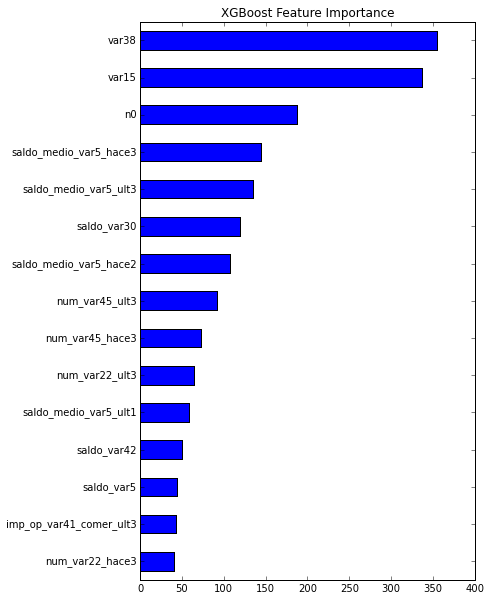

In [21]:
test['n0'] = (test == 0).sum(axis=1)
# test['logvar38'] = test['var38'].map(np.log1p)
# # Encode var36 as category
# test['var36'] = test['var36'].astype('category')
# test = pd.get_dummies(test)
sel_test = test[features]    
y_pred = clf.predict_proba(sel_test, ntree_limit=clf.best_iteration)

submission = pd.DataFrame({"ID":test.index, "TARGET":y_pred[:,1]})
submission.to_csv("submission.csv", index=False)

mapFeat = dict(zip(["f"+str(i) for i in range(len(features))],features))
ts = pd.Series(clf.booster().get_fscore())
#ts.index = ts.reset_index()['index'].map(mapFeat)
ts.sort_values()[-15:].plot(kind="barh", title=("features importance"))

featp = ts.sort_values()[-15:].plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance')
fig_featp = featp.get_figure()
fig_featp.savefig('feature_importance_xgb.png', bbox_inches='tight', pad_inches=1)

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.head()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000,0
3,8,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000,0
4,10,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0


In [4]:
test.head()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var29_ult3,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38
0,2,2,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40532.10
1,5,2,35,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45486.72
2,6,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46993.95
3,7,2,24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,187898.61
4,9,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,73649.73


In [5]:
train.describe()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,...,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,...,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,1.826646e+05,0.194945
min,1.000000,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.163750e+03,0.000000
25%,38104.750000,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.787061e+04,0.000000
50%,76043.000000,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.064092e+05,0.000000
75%,113748.750000,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.187563e+05,0.000000
max,151838.000000,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,6600.000000,6600.000000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,2.203474e+07,1.000000


In [6]:
for i in train.keys():
    print i,train[i].describe()

ID count     76020.000000
mean      75964.050723
std       43781.947379
min           1.000000
25%       38104.750000
50%       76043.000000
75%      113748.750000
max      151838.000000
Name: ID, dtype: float64
var3 count     76020.000000
mean      -1523.199277
std       39033.462364
min     -999999.000000
25%           2.000000
50%           2.000000
75%           2.000000
max         238.000000
Name: var3, dtype: float64
var15 count    76020.000000
mean        33.212865
std         12.956486
min          5.000000
25%         23.000000
50%         28.000000
75%         40.000000
max        105.000000
Name: var15, dtype: float64
imp_ent_var16_ult1 count     76020.000000
mean         86.208265
std        1614.757313
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      210000.000000
Name: imp_ent_var16_ult1, dtype: float64
imp_op_var39_comer_ult1 count    76020.000000
mean        72.363067
std        339.315831
min          0.000000
25%   

In [7]:
for i in test.keys():
    print i,test[i].describe()

ID count     75818.000000
mean      75874.830581
std       43882.370827
min           2.000000
25%       37840.250000
50%       75810.000000
75%      113996.500000
max      151837.000000
Name: ID, dtype: float64
var3 count     75818.000000
mean      -1579.955011
std       39752.473358
min     -999999.000000
25%           2.000000
50%           2.000000
75%           2.000000
max         238.000000
Name: var3, dtype: float64
var15 count    75818.000000
mean        33.138832
std         12.932000
min          5.000000
25%         23.000000
50%         27.000000
75%         39.000000
max        105.000000
Name: var15, dtype: float64
imp_ent_var16_ult1 count     75818.000000
mean         83.164329
std        1694.873886
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      240000.000000
Name: imp_ent_var16_ult1, dtype: float64
imp_op_var39_comer_ult1 count    75818.000000
mean        74.312894
std        364.211245
min          0.000000
25%   

In [8]:
train.var3[train.var3==min(train.var3)]=2
test.var3[test.var3==min(test.var3)]=2

/home/ubuntu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/ubuntu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [9]:
from sklearn import ensemble #импортируем ensemble
import sklearn.cross_validation #импортируем кросс-валидацию

In [10]:
train_target = train['TARGET']

In [11]:
train = train.drop(['TARGET','ID'],axis=1)

In [12]:
test = test.drop(['ID'],axis=1)

In [13]:
# drop unnecessary columns, these columns won't be useful in analysis and prediction

# 1. constant columns
columns_to_be_removed = []
cunt_constant = 0

for col in train.columns:
    if train[col].std() == 0:
        columns_to_be_removed.append(col)
        cunt_constant =  cunt_constant + 1

train.drop(columns_to_be_removed, axis=1, inplace=True)
test.drop(columns_to_be_removed, axis=1, inplace=True)

# 2. duplicated columns
columns_to_be_removed = []
cunt_duplicates = 0

for col_i in train.columns:
    for col_j in train.columns:
        if(col_i == col_j): continue
        if((train[col_i] == train[col_j]).all()):
            columns_to_be_removed.append(col_i)
            cunt_duplicates = cunt_duplicates + 1
            break
            
train.drop(columns_to_be_removed, axis=1, inplace=True)
test.drop(columns_to_be_removed, axis=1, inplace=True)

In [14]:
from sklearn import cross_validation#импорт кросс-валидации
kf = cross_validation.KFold(len(train),n_folds=5,shuffle=True)#задаем кросс-валидацию

In [15]:
ratio = float(np.sum(train_target == 1)) / np.sum(train_target==0)

In [16]:
from sklearn.metrics import roc_auc_score

In [17]:
X_train, X_test, y_train, y_test = \
  cross_validation.train_test_split(train, train_target, stratify=train_target, test_size=0.3)

for i in range(1,6):
    clf = xgb.XGBClassifier(missing=9999999999,
                    max_depth = 7,
                    n_estimators=1000,
                    learning_rate=0.1, 
                    nthread=4,
                    subsample=1.0,
                    colsample_bytree=0.5,
                    min_child_weight = i,
                    scale_pos_weight = ratio,
                    seed=4242)

    clf.fit(X_train, y_train, early_stopping_rounds=50, eval_metric="auc",
            eval_set=[(X_train, y_train), (X_test, y_test)])

    print('Overall AUC:', roc_auc_score(train_target, clf.predict_proba(train, ntree_limit=clf.best_iteration)[:,1]))

Will train until validation_1 error hasn't decreased in 50 rounds.
[0]	validation_0-auc:0.500000	validation_1-auc:0.500000
[1]	validation_0-auc:0.500000	validation_1-auc:0.500000
[2]	validation_0-auc:0.500000	validation_1-auc:0.500000
[3]	validation_0-auc:0.500000	validation_1-auc:0.500000
[4]	validation_0-auc:0.500000	validation_1-auc:0.500000
[5]	validation_0-auc:0.500000	validation_1-auc:0.500000
[6]	validation_0-auc:0.500000	validation_1-auc:0.500000
[7]	validation_0-auc:0.500000	validation_1-auc:0.500000
[8]	validation_0-auc:0.500000	validation_1-auc:0.500000
[9]	validation_0-auc:0.500000	validation_1-auc:0.500000
[10]	validation_0-auc:0.500000	validation_1-auc:0.500000
[11]	validation_0-auc:0.500000	validation_1-auc:0.500000
[12]	validation_0-auc:0.500000	validation_1-auc:0.500000
[13]	validation_0-auc:0.500000	validation_1-auc:0.500000
[14]	validation_0-auc:0.500000	validation_1-auc:0.500000
[15]	validation_0-auc:0.500000	validation_1-auc:0.500000
[16]	validation_0-auc:0.500000	

('Overall AUC:', 0.86120080969275214)


Will train until validation_1 error hasn't decreased in 50 rounds.
[0]	validation_0-auc:0.500000	validation_1-auc:0.500000
[1]	validation_0-auc:0.500000	validation_1-auc:0.500000
[2]	validation_0-auc:0.500000	validation_1-auc:0.500000
[3]	validation_0-auc:0.500000	validation_1-auc:0.500000
[4]	validation_0-auc:0.500000	validation_1-auc:0.500000
[5]	validation_0-auc:0.500000	validation_1-auc:0.500000
[6]	validation_0-auc:0.500000	validation_1-auc:0.500000
[7]	validation_0-auc:0.500000	validation_1-auc:0.500000
[8]	validation_0-auc:0.500000	validation_1-auc:0.500000
[9]	validation_0-auc:0.500000	validation_1-auc:0.500000
[10]	validation_0-auc:0.500000	validation_1-auc:0.500000
[11]	validation_0-auc:0.500000	validation_1-auc:0.500000
[12]	validation_0-auc:0.500000	validation_1-auc:0.500000
[13]	validation_0-auc:0.500000	validation_1-auc:0.500000
[14]	validation_0-auc:0.500000	validation_1-auc:0.500000
[15]	validation_0-auc:0.500000	validation_1-auc:0.500000
[16]	validation_0-auc:0.500000	

('Overall AUC:', 0.85561083171550933)


Will train until validation_1 error hasn't decreased in 50 rounds.
[0]	validation_0-auc:0.500000	validation_1-auc:0.500000
[1]	validation_0-auc:0.500000	validation_1-auc:0.500000
[2]	validation_0-auc:0.500000	validation_1-auc:0.500000
[3]	validation_0-auc:0.500000	validation_1-auc:0.500000
[4]	validation_0-auc:0.500000	validation_1-auc:0.500000
[5]	validation_0-auc:0.500000	validation_1-auc:0.500000
[6]	validation_0-auc:0.500000	validation_1-auc:0.500000
[7]	validation_0-auc:0.500000	validation_1-auc:0.500000
[8]	validation_0-auc:0.500000	validation_1-auc:0.500000
[9]	validation_0-auc:0.500000	validation_1-auc:0.500000
[10]	validation_0-auc:0.500000	validation_1-auc:0.500000
[11]	validation_0-auc:0.500000	validation_1-auc:0.500000
[12]	validation_0-auc:0.500000	validation_1-auc:0.500000
[13]	validation_0-auc:0.500000	validation_1-auc:0.500000
[14]	validation_0-auc:0.500000	validation_1-auc:0.500000
[15]	validation_0-auc:0.500000	validation_1-auc:0.500000
[16]	validation_0-auc:0.500000	

('Overall AUC:', 0.85426682902460804)


Will train until validation_1 error hasn't decreased in 50 rounds.
[0]	validation_0-auc:0.500000	validation_1-auc:0.500000
[1]	validation_0-auc:0.500000	validation_1-auc:0.500000
[2]	validation_0-auc:0.500000	validation_1-auc:0.500000
[3]	validation_0-auc:0.500000	validation_1-auc:0.500000
[4]	validation_0-auc:0.500000	validation_1-auc:0.500000
[5]	validation_0-auc:0.500000	validation_1-auc:0.500000
[6]	validation_0-auc:0.500000	validation_1-auc:0.500000
[7]	validation_0-auc:0.500000	validation_1-auc:0.500000
[8]	validation_0-auc:0.500000	validation_1-auc:0.500000
[9]	validation_0-auc:0.500000	validation_1-auc:0.500000
[10]	validation_0-auc:0.500000	validation_1-auc:0.500000
[11]	validation_0-auc:0.500000	validation_1-auc:0.500000
[12]	validation_0-auc:0.500000	validation_1-auc:0.500000
[13]	validation_0-auc:0.500000	validation_1-auc:0.500000
[14]	validation_0-auc:0.500000	validation_1-auc:0.500000
[15]	validation_0-auc:0.500000	validation_1-auc:0.500000
[16]	validation_0-auc:0.500000	

('Overall AUC:', 0.85358211026371655)


Will train until validation_1 error hasn't decreased in 50 rounds.
[0]	validation_0-auc:0.500000	validation_1-auc:0.500000
[1]	validation_0-auc:0.500000	validation_1-auc:0.500000
[2]	validation_0-auc:0.500000	validation_1-auc:0.500000
[3]	validation_0-auc:0.500000	validation_1-auc:0.500000
[4]	validation_0-auc:0.500000	validation_1-auc:0.500000
[5]	validation_0-auc:0.500000	validation_1-auc:0.500000
[6]	validation_0-auc:0.500000	validation_1-auc:0.500000
[7]	validation_0-auc:0.500000	validation_1-auc:0.500000
[8]	validation_0-auc:0.500000	validation_1-auc:0.500000
[9]	validation_0-auc:0.500000	validation_1-auc:0.500000
[10]	validation_0-auc:0.500000	validation_1-auc:0.500000
[11]	validation_0-auc:0.500000	validation_1-auc:0.500000
[12]	validation_0-auc:0.500000	validation_1-auc:0.500000
[13]	validation_0-auc:0.500000	validation_1-auc:0.500000
[14]	validation_0-auc:0.500000	validation_1-auc:0.500000
[15]	validation_0-auc:0.500000	validation_1-auc:0.500000
[16]	validation_0-auc:0.500000	

('Overall AUC:', 0.8523634535702963)


In [22]:
print train.keys()
print test.keys()

Index([u'var3', u'var15', u'imp_ent_var16_ult1', u'imp_op_var39_comer_ult1',
       u'imp_op_var39_comer_ult3', u'imp_op_var40_comer_ult1',
       u'imp_op_var40_comer_ult3', u'imp_op_var40_efect_ult1',
       u'imp_op_var40_efect_ult3', u'imp_op_var40_ult1',
       ...
       u'saldo_medio_var29_ult3', u'saldo_medio_var33_hace2',
       u'saldo_medio_var33_hace3', u'saldo_medio_var33_ult1',
       u'saldo_medio_var33_ult3', u'saldo_medio_var44_hace2',
       u'saldo_medio_var44_hace3', u'saldo_medio_var44_ult1',
       u'saldo_medio_var44_ult3', u'var38'],
      dtype='object', length=277)
Index([u'var3', u'var15', u'imp_ent_var16_ult1', u'imp_op_var39_comer_ult1',
       u'imp_op_var39_comer_ult3', u'imp_op_var40_comer_ult1',
       u'imp_op_var40_comer_ult3', u'imp_op_var40_efect_ult1',
       u'imp_op_var40_efect_ult3', u'imp_op_var40_ult1',
       ...
       u'saldo_medio_var29_ult3', u'saldo_medio_var33_hace2',
       u'saldo_medio_var33_hace3', u'saldo_medio_var33_ult1',
       

In [23]:
y_pred = clf.predict_proba(test, ntree_limit=clf.best_iteration)

In [25]:
test2 = pd.read_csv('test.csv')
id = test2['ID']

In [26]:
submission = pd.DataFrame({"ID":id, "TARGET":y_pred[:,1]})
submission.to_csv("submission.csv", index=False)